# Zero-Shot CLIP Inference with OpenVINO

This notebook performs image and text-based search using zero-shot CLIP model optimized with OpenVINO.

In [4]:
import os
import numpy as np
import pickle
from pathlib import Path
from PIL import Image
import torch
import clip
from openvino.runtime import Core
import faiss
import matplotlib.pyplot as plt

## Configuration

In [5]:
MODEL_DIR = Path(r"e:\Projects\AI Based\RecTrio\V2\models")
VECTOR_DB_DIR = Path(r"e:\Projects\AI Based\RecTrio\V2\vector_db")

CLIP_MODEL_NAME = "ViT-B/32"  # Fast GitHub CLIP model
VISION_MODEL_PATH = MODEL_DIR / "clip_vision_model.xml"
TEXT_MODEL_PATH = MODEL_DIR / "clip_text_model.xml"
FAISS_INDEX_PATH = VECTOR_DB_DIR / "faiss_index.bin"
METADATA_PATH = VECTOR_DB_DIR / "metadata.pkl"

TOP_K = 10

## Load Processor and Model Components

In [6]:
print("Loading CLIP model (fast GitHub version)...")
model, preprocess = clip.load(CLIP_MODEL_NAME, device="cpu")
model.eval()
print(f"✓ CLIP {CLIP_MODEL_NAME} loaded successfully (in ~2-3 seconds!)")

Loading CLIP model (fast GitHub version)...
✓ CLIP ViT-B/32 loaded successfully (in ~2-3 seconds!)
✓ CLIP ViT-B/32 loaded successfully (in ~2-3 seconds!)


## Load OpenVINO Models

In [7]:
core = Core()

print("Loading vision model...")
vision_compiled_model = core.compile_model(str(VISION_MODEL_PATH), "CPU")
vision_input_layer = vision_compiled_model.input(0)
vision_output_layer = vision_compiled_model.output(0)

print("Loading text model...")
text_compiled_model = core.compile_model(str(TEXT_MODEL_PATH), "CPU")
text_output_layer = text_compiled_model.output(0)

print("OpenVINO models loaded on CPU")

Loading vision model...
Loading text model...
Loading text model...
OpenVINO models loaded on CPU
OpenVINO models loaded on CPU


## Load FAISS Index and Metadata

In [8]:
print("Loading FAISS index...")
index = faiss.read_index(str(FAISS_INDEX_PATH))
print(f"Loaded index with {index.ntotal} vectors")

print("Loading metadata...")
with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

image_paths = metadata['image_paths']
print(f"Loaded {len(image_paths)} image paths")

Loading FAISS index...
Loaded index with 26179 vectors
Loading metadata...
Loaded 26179 image paths


## Embedding Functions

In [ ]:
def get_image_embedding(image_input):
    """Generate image embedding using OpenVINO vision model"""
    if isinstance(image_input, str):
        image = Image.open(image_input).convert('RGB')
    else:
        image = image_input.convert('RGB')
    
    image_tensor = preprocess(image).unsqueeze(0)
    pixel_values = image_tensor.numpy()
    
    # Run inference with OpenVINO
    result = vision_compiled_model([pixel_values])[vision_output_layer]
    
    # Get embedding and normalize
    embedding = result[0]
    embedding = embedding / np.linalg.norm(embedding)
    
    return embedding.astype('float32')

def get_text_embedding(text):
    """Generate text embedding using OpenVINO text model"""
    # Use CLIP's tokenization
    text_tokens = clip.tokenize([text])
    
    # Run inference with OpenVINO
    result = text_compiled_model([text_tokens.numpy()])[text_output_layer]
    
    # Get embedding and normalize
    embedding = result[0]
    embedding = embedding / np.linalg.norm(embedding)
    
    return embedding.astype('float32')

## Search Function

In [10]:
def search_similar_images(query_embedding, top_k=TOP_K):
    query_embedding = query_embedding.reshape(1, -1)
    
    distances, indices = index.search(query_embedding, top_k)
    
    results = []
    for idx, dist in zip(indices[0], distances[0]):
        results.append({
            'path': image_paths[idx],
            'similarity': float(dist)
        })
    
    return results

## Visualization Function

In [11]:
def display_results(results, query_info=None):
    n_results = len(results)
    cols = 5
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if n_results > 1 else [axes]
    
    for idx, result in enumerate(results):
        img = Image.open(result['path'])
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Similarity: {result['similarity']:.4f}", fontsize=10)
    
    for idx in range(n_results, len(axes)):
        axes[idx].axis('off')
    
    if query_info:
        fig.suptitle(f"Query: {query_info}", fontsize=14, y=1.00)
    
    plt.tight_layout()
    plt.show()

## Image-Based Search

Searching for images similar to: e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1.jpeg

Top 10 similar images:
1. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1.jpeg (Similarity: 1.0000)
2. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\41.jpeg (Similarity: 0.9357)
3. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\51.jpeg (Similarity: 0.9271)
4. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\944.jpeg (Similarity: 0.9261)
5. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\547.jpeg (Similarity: 0.9255)
6. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\477.jpeg (Similarity: 0.9228)
7. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\44.jpeg (Similarity: 0.9169)
8. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1002.jpeg (Similarity: 0.9164)
9. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\442.jpeg (Similarity: 0.9163)
10. e:\Projects\AI Based\RecTrio\

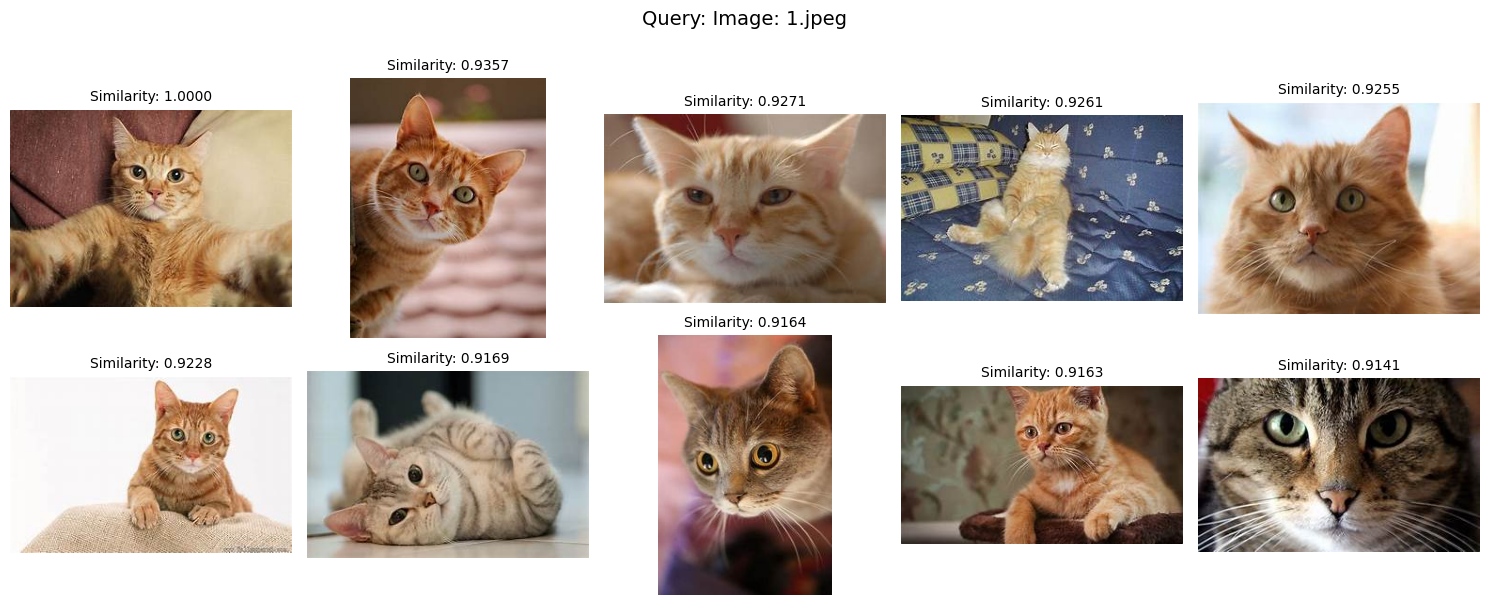

In [12]:
query_image_path = r"e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1.jpeg"

print(f"Searching for images similar to: {query_image_path}")
query_embedding = get_image_embedding(query_image_path)
results = search_similar_images(query_embedding)

print(f"\nTop {len(results)} similar images:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")

display_results(results, query_info=f"Image: {Path(query_image_path).name}")

## Text-Based Search

Searching for: 'a photo of a cat'

Top 10 similar images:
1. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1543.jpeg (Similarity: 0.3088)
2. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ee32b90c29f11c22d2524518b7444f92e37fe5d404b0144390f8c079a4e5b6_640.jpg (Similarity: 0.3077)
3. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ea37b1092cf4053ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg (Similarity: 0.3074)
4. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\702.jpeg (Similarity: 0.3062)
5. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ea36b20c2ff2003ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg (Similarity: 0.3058)
6. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1769.jpeg (Similarity: 0.3056)
7. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ea37b6072df1023ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg (Similarity: 0.3052)
8. e:\Projects\AI Based\RecT

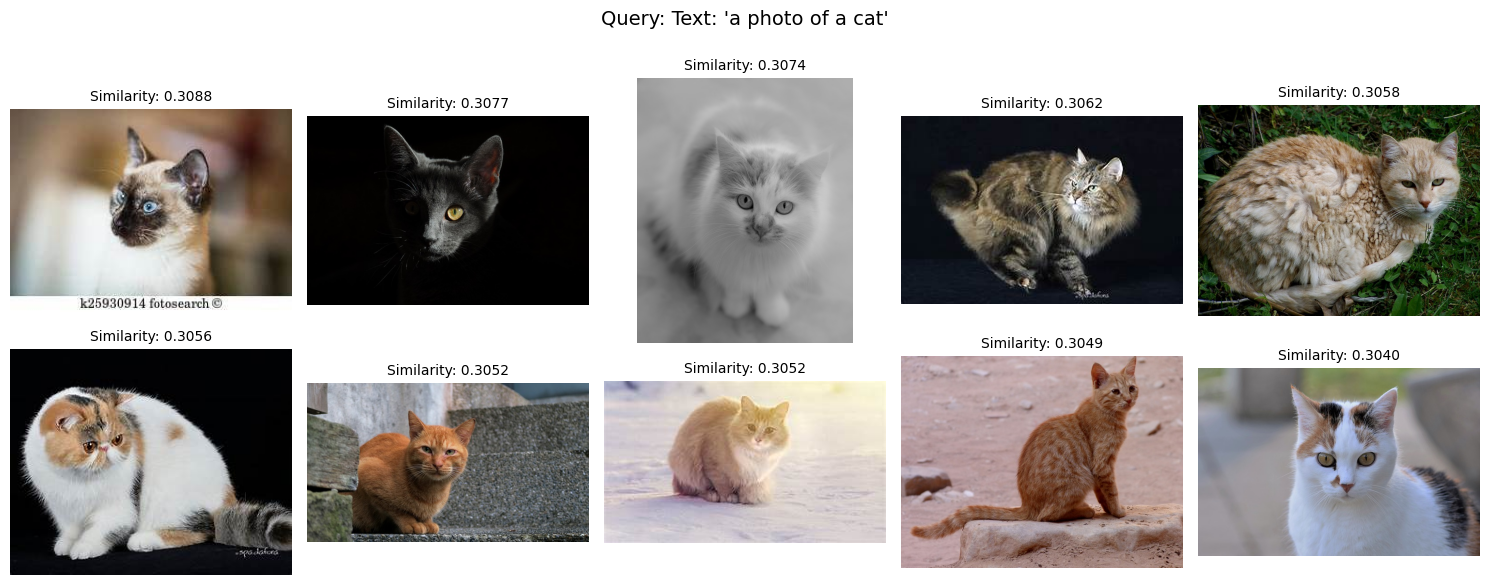

In [13]:
query_text = "a photo of a cat"

print(f"Searching for: '{query_text}'")
query_embedding = get_text_embedding(query_text)
results = search_similar_images(query_embedding)

print(f"\nTop {len(results)} similar images:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")

display_results(results, query_info=f"Text: '{query_text}'")

## Interactive Search

Choose search type:
1. Image search
2. Text search

Searching for images similar to: E:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-_5bWJ7SoPigN4PgV6UozJAHaEo.jpeg

Top 10 similar images:
1. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-_5bWJ7SoPigN4PgV6UozJAHaEo.jpeg (Similarity: 1.0000)
2. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-5ZwfeYunG6CT2wEI7OjybQHaEo.jpeg (Similarity: 0.9392)
3. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-ZoYZzBjBgliTblAgXK-udwHaFj.jpeg (Similarity: 0.9352)
4. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-Uj1GtYLItwJxnT-wNHdXZAHaEo.jpeg (Similarity: 0.9322)
5. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-wdYoc2SpAQc0tDzqLVclvAHaEo.jpeg (Similarity: 0.9321)
6. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\squirrel\OIP-3X1SlRUeStD7EZoLbrbxUgHaFP.jpeg (Similarity: 0.9312)
7. e:\Projects\AI Based\RecTrio\V

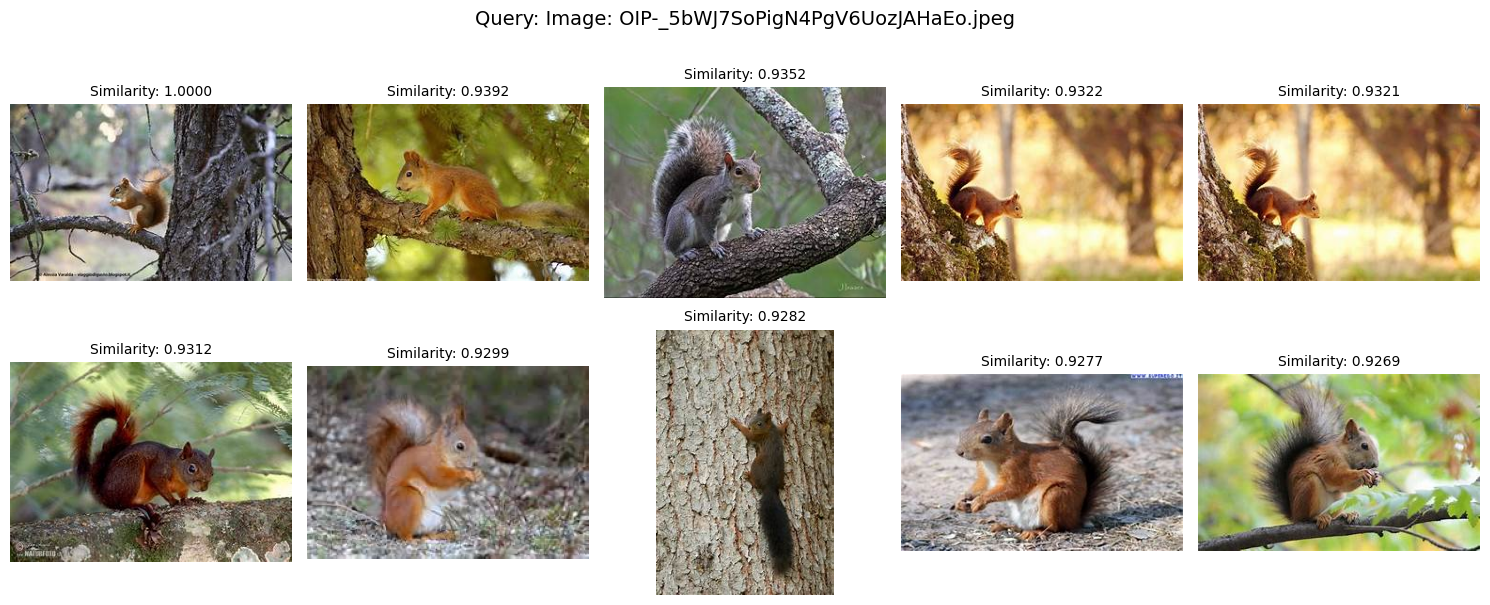

In [ ]:
def interactive_search():
    print("Choose search type:")
    print("1. Image search")
    print("2. Text search")
    
    choice = input("Enter choice (1-image or 2-text): ").strip()
    
    if choice == "1":
        image_path = input("Enter image path: ").strip()
        if not os.path.exists(image_path):
            print("Image not found!")
            return
        
        print(f"\nSearching for images similar to: {image_path}")
        query_embedding = get_image_embedding(image_path)
        results = search_similar_images(query_embedding)
        
        print(f"\nTop {len(results)} similar images:")
        for i, result in enumerate(results, 1):
            print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")
        
        display_results(results, query_info=f"Image: {Path(image_path).name}")
        
    elif choice == "2":
        text_query = input("Enter search text: ").strip()
        
        print(f"\nSearching for: '{text_query}'")
        query_embedding = get_text_embedding(text_query)
        results = search_similar_images(query_embedding)
        
        print(f"\nTop {len(results)} similar images:")
        for i, result in enumerate(results, 1):
            print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")
        
        display_results(results, query_info=f"Text: '{text_query}'")
    else:
        print("Invalid choice!")

interactive_search()